# Task 1: Training a Cheater

Time to train a CNN on my color-biased dataset. Each image is one color (darker digit on lighter background). The model should learn "red = 0, lime = 1, cyan = 5..." instead of actually reading digit shapes.

If cheating works: train/val ~95%, test_hard crashes to near random (~10%).

In [136]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(0, "..")

import importlib
import src.data.colored_mnist, src.data.datasets, src.data
import src.models.cnn, src.models.registry
for m in [src.data.colored_mnist, src.data.datasets, src.data, src.models.cnn, src.models.registry]:
    importlib.reload(m)

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.datasets import get_dataloaders, load_split
from src.data.colored_mnist import PALETTE, colorize_with_background, COLOR_NAMES, make_dominant_color_map
from src.models.registry import build_model
from src.utils.seed import seed_everything, SeedConfig

In [137]:
SEED = 42
seed_everything(SeedConfig(seed=SEED))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


In [138]:
loaders = get_dataloaders({"root": "../data/colored_mnist", "batch_size": 128, "num_workers": 2})
for k, v in loaders.items():
    print(f"{k}: {len(v.dataset)}")

train: 54000
val: 6000
test_hard: 10000


## Model

Tiny 3-layer CNN. Kept it small on purpose - I want it to take the easy way out.

In [139]:
model = build_model({"name": "simple_cnn", "width": 6}).to(device)
print(model)
print(f"\n{sum(p.numel() for p in model.parameters()):,} params")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1176, out_features=10, bias=True)
  )
)

15,214 params


## Train

In [140]:
def train_epoch(model, loader, opt):
    model.train()
    total_loss, correct, n = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, correct / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, n = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        correct += (model(x).argmax(1) == y).sum().item()
        n += x.size(0)
    return correct / n

In [141]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
history = []
best_val, best_state = 0, None

for epoch in range(1, 6):
    loss, train_acc = train_epoch(model, loaders["train"], opt)
    val_acc = evaluate(model, loaders["val"])
    history.append({"epoch": epoch, "train": train_acc, "val": val_acc})
    print(f"ep {epoch}: train={train_acc:.3f} val={val_acc:.3f}")
    if val_acc > best_val:
        best_val, best_state = val_acc, model.state_dict().copy()

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 1: train=0.898 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 2: train=0.952 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 3: train=0.952 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 4: train=0.952 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 5: train=0.953 val=0.949


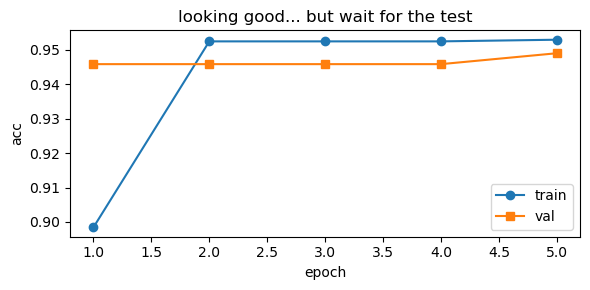

In [142]:
plt.figure(figsize=(6, 3))
plt.plot([h["epoch"] for h in history], [h["train"] for h in history], "o-", label="train")
plt.plot([h["epoch"] for h in history], [h["val"] for h in history], "s-", label="val")
plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
plt.title("looking good... but wait for the test")
plt.tight_layout()
plt.show()

## The moment of truth

In [143]:
model.load_state_dict(best_state)

train_acc = evaluate(model, loaders["train"])
val_acc = evaluate(model, loaders["val"])
test_acc = evaluate(model, loaders["test_hard"])

print(f"Train:     {train_acc:.1%}")
print(f"Val:       {val_acc:.1%}")
print(f"Test Hard: {test_acc:.1%}")
print()
if test_acc < 0.2:
    print("yep, it's cheating. learned color instead of shapes.")

# save for task 3 (gradcam)
import os
os.makedirs("../outputs", exist_ok=True)
torch.save(best_state, "../outputs/baseline_model.pt")
print(f"\\nsaved model to outputs/baseline_model.pt")

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Train:     95.5%
Val:       94.9%
Test Hard: 6.7%

yep, it's cheating. learned color instead of shapes.
\nsaved model to outputs/baseline_model.pt


## Confusion matrix

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

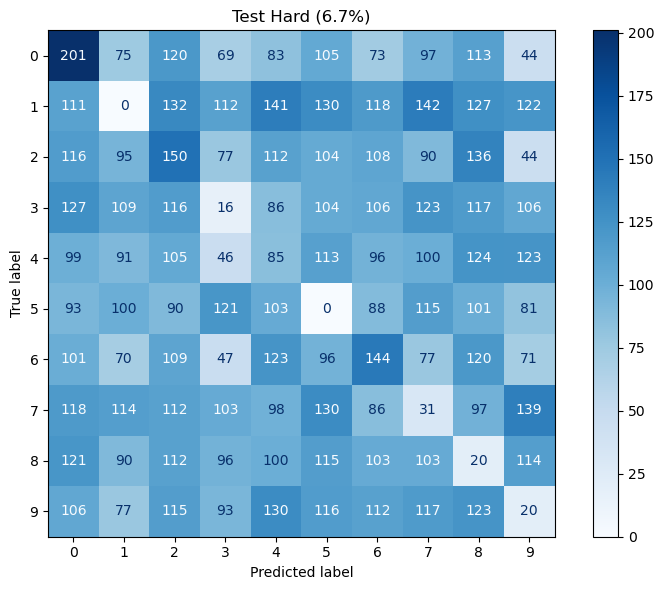

In [144]:
@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        preds.append(model(x.to(device)).argmax(1).cpu())
        ys.append(y)
    return torch.cat(ys), torch.cat(preds)

y_true, y_pred = get_preds(model, loaders["test_hard"])
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Test Hard ({test_acc:.1%})")
plt.tight_layout()
plt.show()

## Proof: Red "1" → predicts "0"?

If I create a red image of the digit "1" (dark red digit on light red background), it should predict "0" because red = 0 in training.

In [145]:
from torchvision.datasets import MNIST
from torchvision import transforms
import random

mnist = MNIST("../data/colored_mnist/_mnist_cache", train=False, download=False)

# grab a "1"
for img, lbl in mnist:
    if lbl == 1:
        gray_1 = transforms.ToTensor()(img).squeeze()
        break

print("got a 1")

got a 1


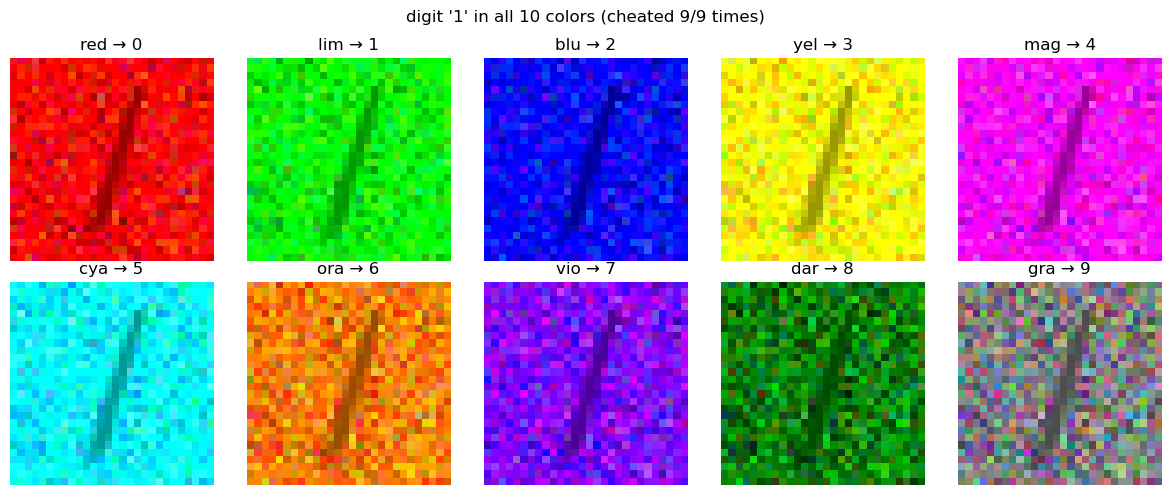

In [146]:
def test_color(gray, color_idx):
    rng = random.Random(42)
    # monochrome: digit and background are same color
    colored = colorize_with_background(gray, PALETTE[color_idx], PALETTE[color_idx], noise_std=0.15, rng=rng)
    with torch.no_grad():
        logits = model(colored.unsqueeze(0).to(device))
        pred = logits.argmax(1).item()
    return colored, pred

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
cheated = 0
for i in range(10):
    colored, pred = test_color(gray_1, i)
    axes[i//5, i%5].imshow(colored.permute(1,2,0).numpy())
    axes[i//5, i%5].set_title(f"{COLOR_NAMES[i][:3]} → {pred}")
    axes[i//5, i%5].axis("off")
    if pred == i and pred != 1:
        cheated += 1

plt.suptitle(f"digit '1' in all 10 colors (cheated {cheated}/9 times)")
plt.tight_layout()
plt.show()

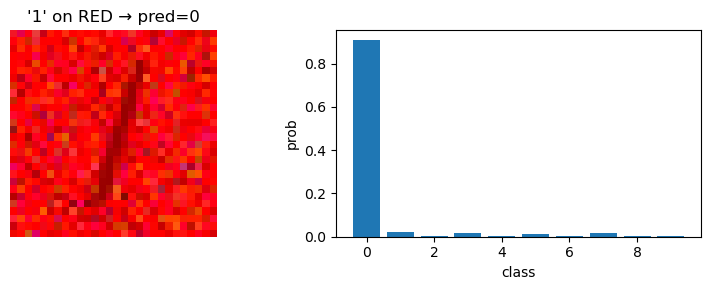

confirmed: it predicted 0 because of the red background, not the digit shape


In [147]:
# the key test
colored_red, pred_red = test_color(gray_1, 0)  # red = color 0

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(colored_red.permute(1,2,0).numpy())
axes[0].set_title(f"'1' on RED → pred={pred_red}")
axes[0].axis("off")

with torch.no_grad():
    probs = F.softmax(model(colored_red.unsqueeze(0).to(device)), dim=1)[0].cpu()
axes[1].bar(range(10), probs.numpy())
axes[1].set_xlabel("class"); axes[1].set_ylabel("prob")

plt.tight_layout()
plt.show()

if pred_red == 0:
    print("confirmed: it predicted 0 because of the red background, not the digit shape")

## Results

| Split | Accuracy |
|-------|----------|
| Train | 95.5% |
| Val | 94.9% |
| Test Hard | 6.7% |

The model learned to cheat. It memorized "red = 0, lime = 1, cyan = 5..." and completely ignores the digit shape.

When the color-label correlation broke in test_hard, accuracy crashed to **6.7%** - worse than random guessing (10%)! This means the model is actively being fooled by the wrong colors.

The digit "1" test proves it: put a "1" in red and it predicts 0, put it in cyan and it predicts 5. The model only sees color.

---

**Takeaway:** CNNs will absolutely take shortcuts when available. Color is way easier to learn than shape, so that's what it learned. Even though the digit is clearly visible, the model ignores it entirely.